In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
import torch
from torch.autograd import Variable
from networks.FuseNet_20180906 import FuseNet_20180906, CrossEntropy2d
from Solver_FuseNet import Solver_SS
import torch.nn.functional as F

from dataloaders.NYUDv2Loader_HHA import *
from dataloaders.SUNRGBDLoader_HHA import *

%matplotlib inline
from utils.visual_utils import *

%load_ext autoreload
%autoreload 2

In [3]:
def evaluate(model, num_classes, val_loader, data_type):
    # Calculate IoU and Mean accuracies
    print num_classes
    val_confusion = np.zeros((num_classes,3))
    IoU = 0
    mean_acc = 0

    for batch in val_loader:
        val_rgb_inputs  = Variable(batch[0].cuda(gpu_device))
        val_d_inputs    = Variable(batch[1].cuda(gpu_device))
        val_labels      = Variable(batch[2].cuda(gpu_device))
        val_outputs     = model(val_rgb_inputs, val_d_inputs)
        _, val_preds    = torch.max	(val_outputs, 1)

        if (data_type == 'sun' or data_type == 'SUN'):
            val_labels = val_labels - 1     # sun
        elif (data_type == 'nyu' or data_type == 'NYU'):
            val_preds = val_preds + 1       # nyu

        for i in range(num_classes):
            val_labels_mask = val_labels == i
            val_preds_mask = val_preds == i
            TP = np.sum((val_preds == val_labels)[val_labels_mask].data.cpu().numpy())
            #print TP
            val_confusion[i,0] += TP 
            val_confusion[i,1] += np.sum((val_labels==val_labels)[val_labels_mask].data.cpu().numpy()) - TP 
            val_confusion[i,2] += np.sum((val_preds==val_preds)[val_preds_mask].data.cpu().numpy()) - TP 

    for i in range(num_classes):
        TP, FP, FN = val_confusion[i]
        print(TP+FP,FN)
        IoU += TP / (TP + FP + FN)
        mean_acc += TP / (TP + FP)
    IoU /= num_classes
    mean_acc /= num_classes

    print("        Best VALIDATION IoU: %.3f Mean Accuracy: %.3f" % (IoU, mean_acc))

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [5]:
data_visualizer = DataVisualizer()

# NYUDv2

In [6]:
gpu_device = 3
num_classes_nyu = 13

In [7]:
v_loader_nyu = NYUDv2Loader_HHA(gpu_device, '/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_nyu = data.DataLoader(v_loader_nyu, batch_size=4, num_workers=16)

In [21]:
model_nyu = FuseNet_20180906(gpu_device, num_classes_nyu, is_HHA=True)
checkpoint = torch.load('../models/nyu_hha/checkpoint25.pth.tar')
model_nyu.load_state_dict(checkpoint['state_dict']) 

In [22]:
sampling_position = 0
for n, sample in enumerate(val_loader_nyu):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_nyu(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    val_preds = val_preds + 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  2  3  5  6  7  8  9 10 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f7cd0417750>> ignored


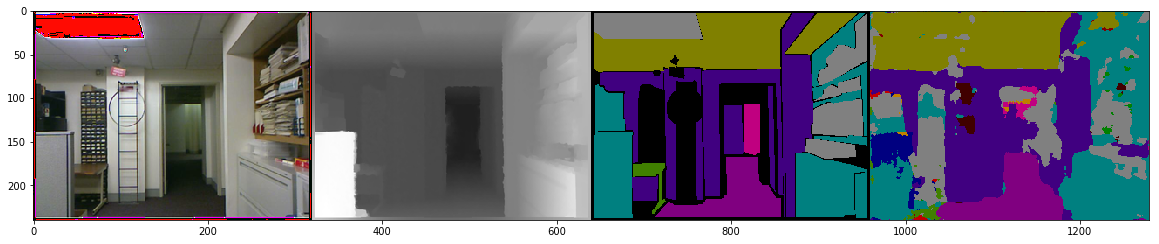

In [24]:
idx = 2
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=True)

In [25]:
evaluate(model_nyu, num_classes_nyu, val_loader_nyu, 'NYU')

13
(8590052.0, 0.0)
(2048477.0, 506189.0)
(330180.0, 146520.0)
(645770.0, 344458.0)
(1640338.0, 946354.0)
(4915685.0, 1375123.0)
(6972920.0, 3714290.0)
(6070799.0, 4631362.0)
(1104096.0, 402870.0)
(1542769.0, 600224.0)
(1778309.0, 922028.0)
(212285.0, 78911.0)
(11829309.0, 4760742.0)
        Best VALIDATION IoU: 0.403 Mean Accuracy: 0.578


## 결론

기존의 fusenet에 HHA 한것은  
(Best VALIDATION IoU: 0.388 Mean Accuracy: 0.560) 이정도 인데  
이것보다 좋긴하다 하지만  
기존의 fusenet의 depth를 사용한것은  
(Best VALIDATION IoU: 0.424 Mean Accuracy: 0.619) 이정도 인데  
이것보다는 안 좋게 나왔다.  
HHA 인풋에 대해서도 정규화가 필요할것 같다.  
정규화 하고 나서는 또 결과가 달라질수 있다.  

# SUNRGBD

In [26]:
gpu_device = 4
num_classes_sun = 38

In [27]:
v_loader_sun = SUNRGBDLoader_HHA(gpu_device, '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_sun = data.DataLoader(v_loader_sun, batch_size=4, num_workers=16)

In [29]:
model_sun = FuseNet_20180906(gpu_device, num_classes_sun, is_HHA=True).cuda()
checkpoint = torch.load('../models/sun_hha/checkpoint25.pth.tar')
model_sun.load_state_dict(checkpoint['state_dict']) 

In [30]:
sampling_position = 14
for n, sample in enumerate(val_loader_sun):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_sun(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    labels = labels - 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  1  2  4  5  6  7  9 10 11 16 21 23 26 35 37]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 19 23 26 36 37]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f7cd05d44d0>> ignored


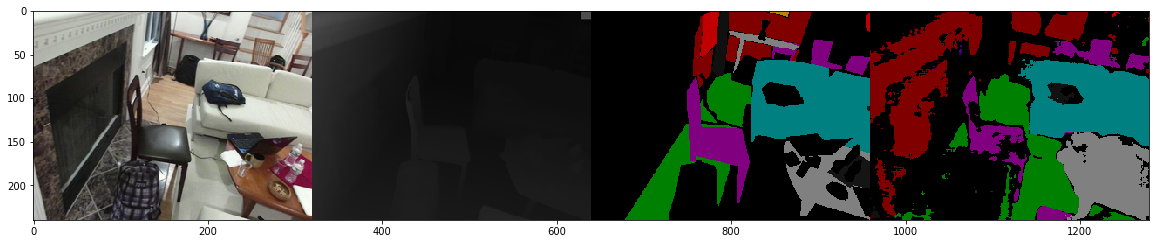

In [31]:
idx = 0
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=True)

In [32]:
evaluate(model_sun, num_classes_sun, val_loader_sun, 'SUN')

38
(100380819.0, 67734819.0)
(76950380.0, 17537473.0)
(66248050.0, 10281814.0)
(8192273.0, 5819652.0)
(8423890.0, 2547979.0)
(30644096.0, 12015258.0)
(8244155.0, 2967386.0)
(24590411.0, 9183792.0)
(8046135.0, 4948000.0)
(8101946.0, 3972984.0)
(2579317.0, 49348.0)
(2263473.0, 365785.0)
(2701786.0, 813357.0)
(1273099.0, 956807.0)
(9681808.0, 1323097.0)
(1101587.0, 15496.0)
(3573950.0, 2259558.0)
(1858656.0, 100317.0)
(1627987.0, 514205.0)
(1528022.0, 677837.0)
(190924.0, 0.0)
(1306164.0, 151835.0)
(3125932.0, 839715.0)
(1578584.0, 298983.0)
(1543665.0, 80715.0)
(552957.0, 18841.0)
(1227810.0, 64762.0)
(579606.0, 11804.0)
(154372.0, 0.0)
(2292851.0, 23057.0)
(2034632.0, 604606.0)
(330616.0, 965.0)
(192364.0, 168.0)
(979421.0, 281682.0)
(1372099.0, 180498.0)
(762264.0, 93336.0)
(602312.0, 155088.0)
(924787.0, 589.0)
        Best VALIDATION IoU: 0.200 Mean Accuracy: 0.268
